# Competition: **Moscow Housing**
## Team Name: **Group 7**
## Team Members:
- **Vegard Skui** (506824)
- **Albert Lesniewski** (488094)
- **Jim Totland** (490741)

Student IDs are given in the parantheses.

# Rough Overview for the Reader 
- Loading Data and Utilites
- Some EDA and a Simple LightGBM Model
- Experiments with PyTorch
- Data cleaning and Feature Engineering
-  Modeling with Tree-Methods and Optuna-tuning.

**Note:** The code writing predictions to deliverable CSV files has been commented out. To use these, a folder named `submissions` must be present in the working directory.

In [147]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import lightgbm as lgb
import contextily as cx
import geopandas as gpd
import optuna
import catboost
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, KFold 

# Set up the KML driver for GeoPandas
gpd.io.file.fiona.drvsupport.supported_drivers["KML"] = "rw"

sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings("ignore")

# Utilities 

In [148]:
SEED = 42

def rmsle(y_true, y_pred):
    # Alternatively: sklearn.metrics.mean_squared_log_error(y_true, y_pred) ** 0.5
    assert (y_true >= 0).all() 
    assert (y_pred >= 0).all()
    log_error = np.log1p(y_pred) - np.log1p(y_true)  # Note: log1p(x) = log(1 + x)
    return np.mean(log_error ** 2) ** 0.5

In [149]:
def plot_feature_importances(names, importances, model_name):
    sort_idx = np.argsort(importances)[::-1]
    sns.barplot(
        y=np.array(names)[sort_idx],
        x=importances[sort_idx],
        palette="summer",
    ).set(title=f"{model_name} Feature Importances")

def plot_hyperparameter_importances(study):
    importances = optuna.importance.get_param_importances(study)
    sns.barplot(
        y=list(importances.keys()),
        x=list(importances.values()),
        palette="Oranges_r",
    ).set(title=f"{study.study_name} Hyperparameter Importances")

# Load Data

In [150]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)
data['split'] = 'train'

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)
data_test['split']  = 'test'

all_data = pd.concat([data, data_test])

# Exploratory Data Analysis
We begin by dividing the feature into categorical and numerical features.

In [151]:
NUMERIC_FEAT = ['area_total', 'area_kitchen', 'area_living', 'floor', 'rooms', 'ceiling', 'bathrooms_shared', 'bathrooms_private', 
                'balconies', 'loggias', 'phones', 'longitude', 'latitude', 'constructed', 'stories']

CATEORICAL_FEAT = ['seller', 'layout', 'windows_court', 'windows_street', 'condition', 'new', 'district', 'material', 
            'elevator_without', 'elevator_service', 'elevator_passenger', 'parking', 'garbage_chute', 'heating']

NO_USE = ['street', 'address']

## Pairs Plot
First we make some pairs-plots between the numerical features and the response:

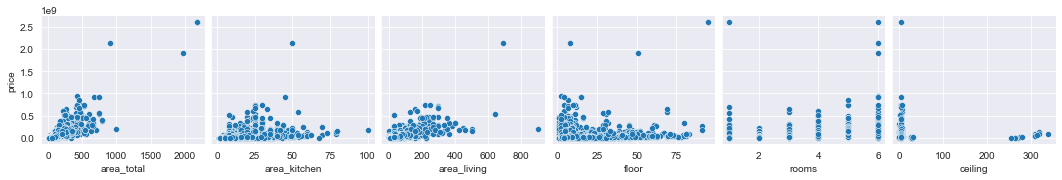

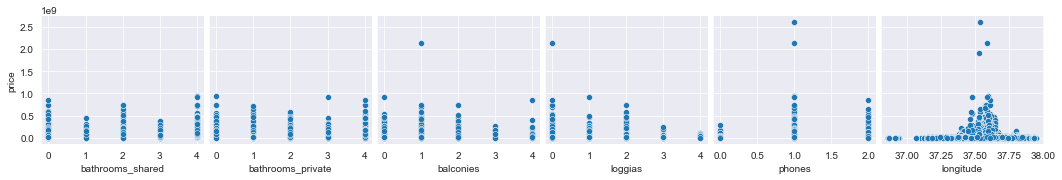

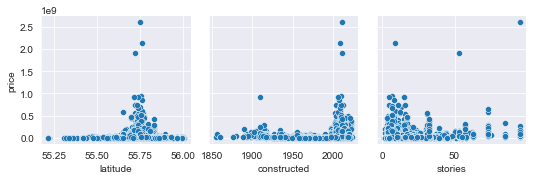

In [152]:
for i in range(0, len(NUMERIC_FEAT), 6):
    sns.pairplot(data=data[NUMERIC_FEAT + ['price']],
                x_vars=NUMERIC_FEAT[i:i+6],
                y_vars=['price'])

We also do a pairs plot with the log of the response:

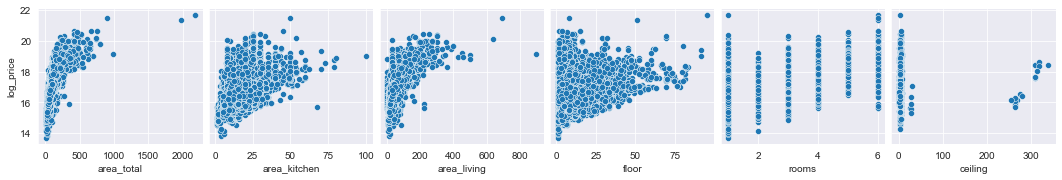

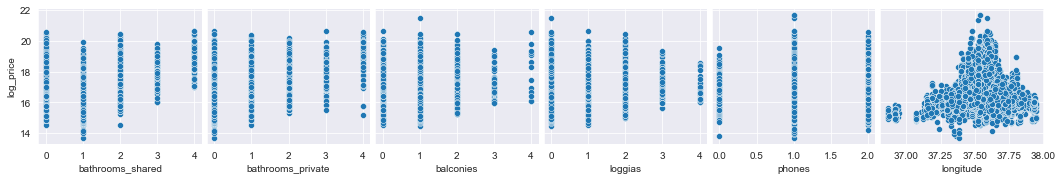

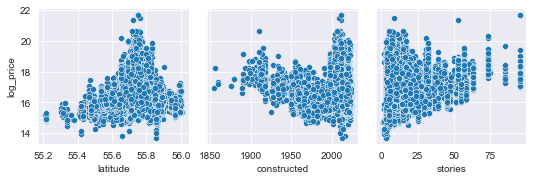

In [153]:
data['log_price'] = np.log(data.price)
for i in range(0, len(NUMERIC_FEAT), 6):
    sns.pairplot(data=data[NUMERIC_FEAT + ['log_price']],
                x_vars=NUMERIC_FEAT[i:i+6],
                y_vars=['log_price'])

From the plots, we see that there is a strong linear relationship between the price and the area-related features, especially `area_total`. `floor`, `rooms` and `stories` also seem to have a linear relationship, at least with the log of the response. It is clear that `longitude` and `latitude` have a nonlinear relationship with the response. Some of these features, e.g. `phones` should maybe be treated as categorical.

## Correlation Matrix
Next, we construct a correlation matrix with both price and numerical features.

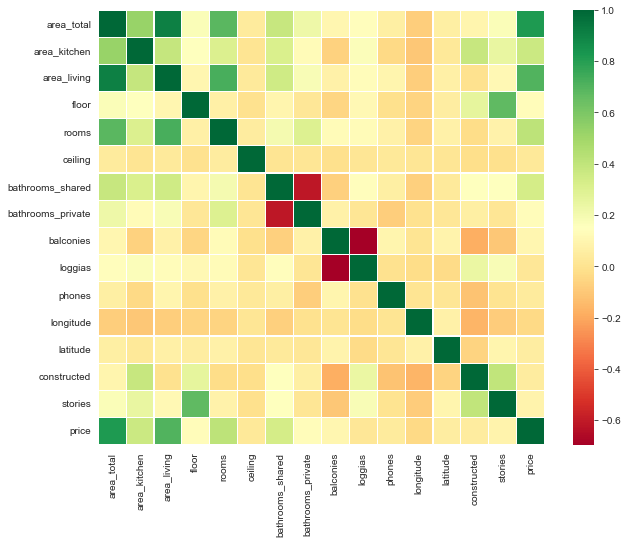

In [154]:
sns.heatmap(data[NUMERIC_FEAT + ['price']].corr(),annot=False,cmap='RdYlGn',linewidths=0.2) #data.corr()-->correlation matrix
fig=plt.gcf()
fig.set_size_inches(10,8)
plt.show()

The correlation matrix confirms the observed relationships in the pairs-plot.



## Categorical Features
Next, we have a look at the categorical features. We include a category for the missing values for each feature.

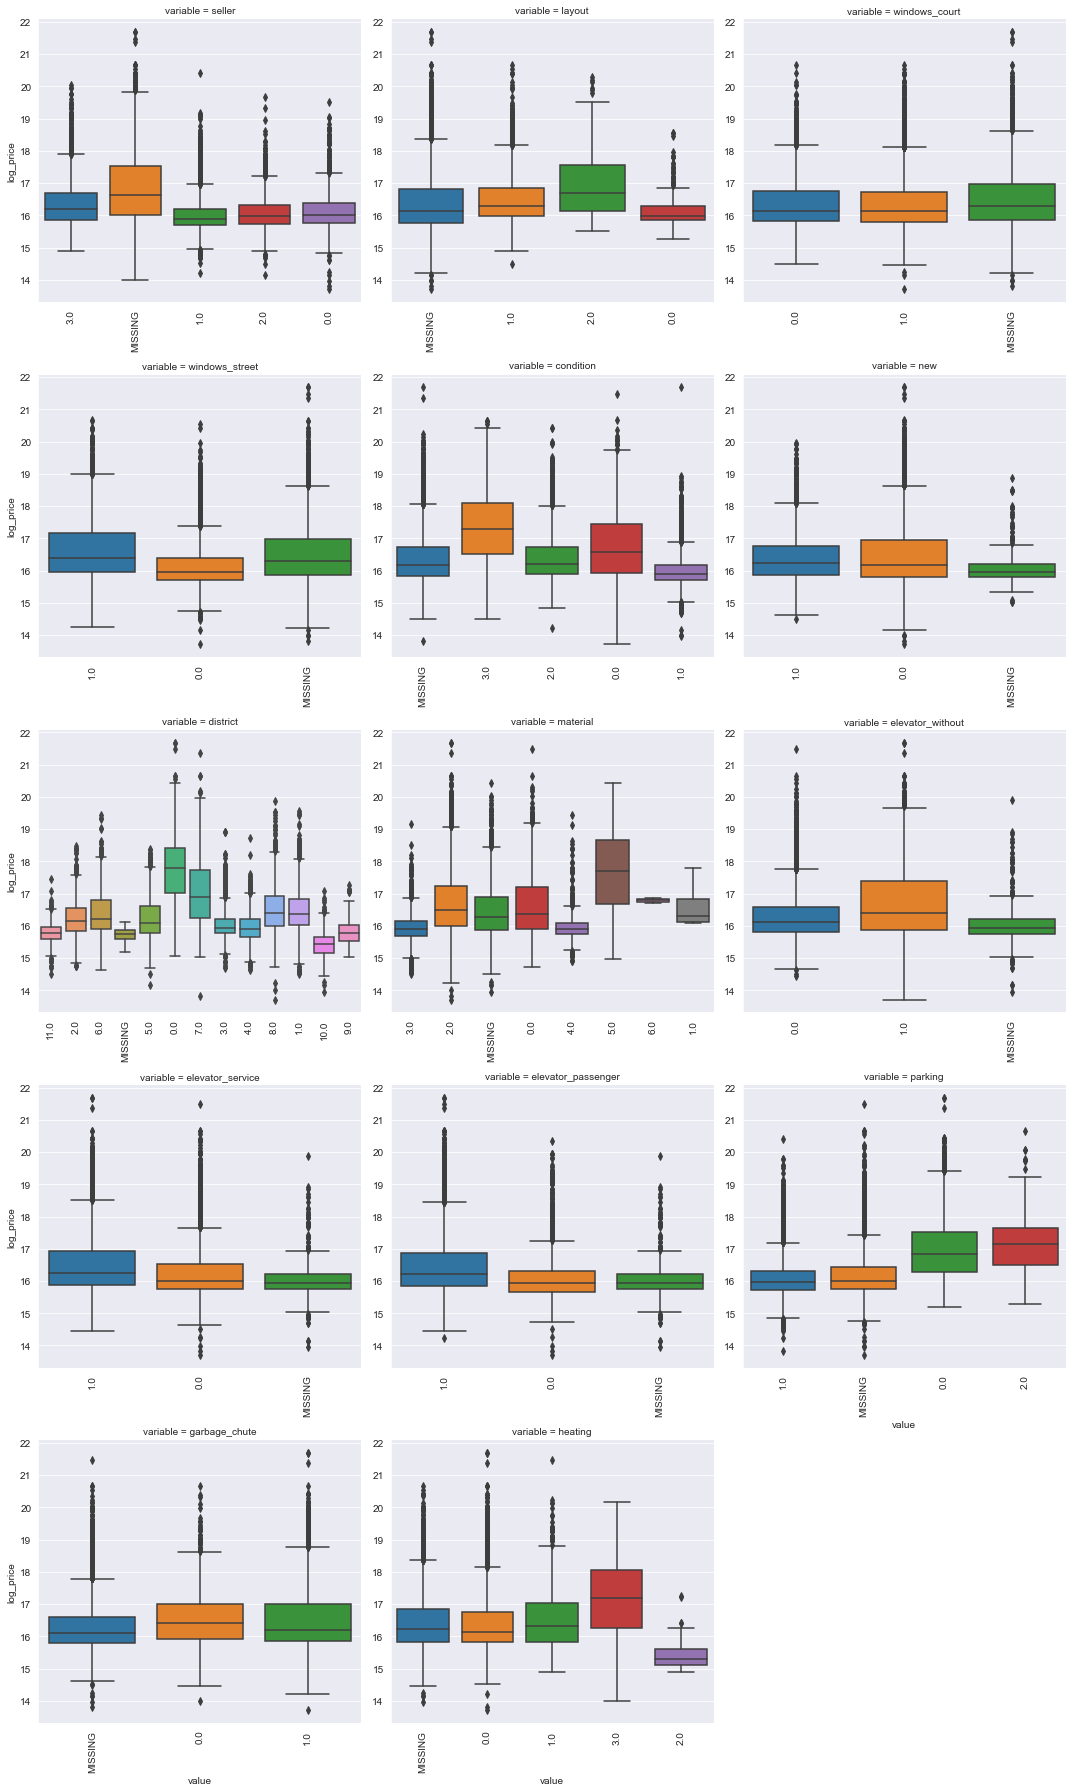

In [155]:
data_cat = data[CATEORICAL_FEAT + ['log_price']].copy() # Use log of price.

for c in CATEORICAL_FEAT:
    data_cat[c] = data_cat[c].astype('category')
    if data_cat[c].isnull().any():
        data_cat[c] = data_cat[c].cat.add_categories(['MISSING'])
        data_cat[c] = data_cat[c].fillna('MISSING')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    x=plt.xticks(rotation=90)

f = pd.melt(data_cat, id_vars=['log_price'], value_vars= CATEORICAL_FEAT)
g = sns.FacetGrid(f, col="variable",  col_wrap=3, sharex=False, sharey=False, height=5)
g = g.map(boxplot, "value", "log_price")

From the plot, `district` seems to be important. `material`, `heating` and `parking`also seem to have some important price differences among categories.



## Exploring Missing Values

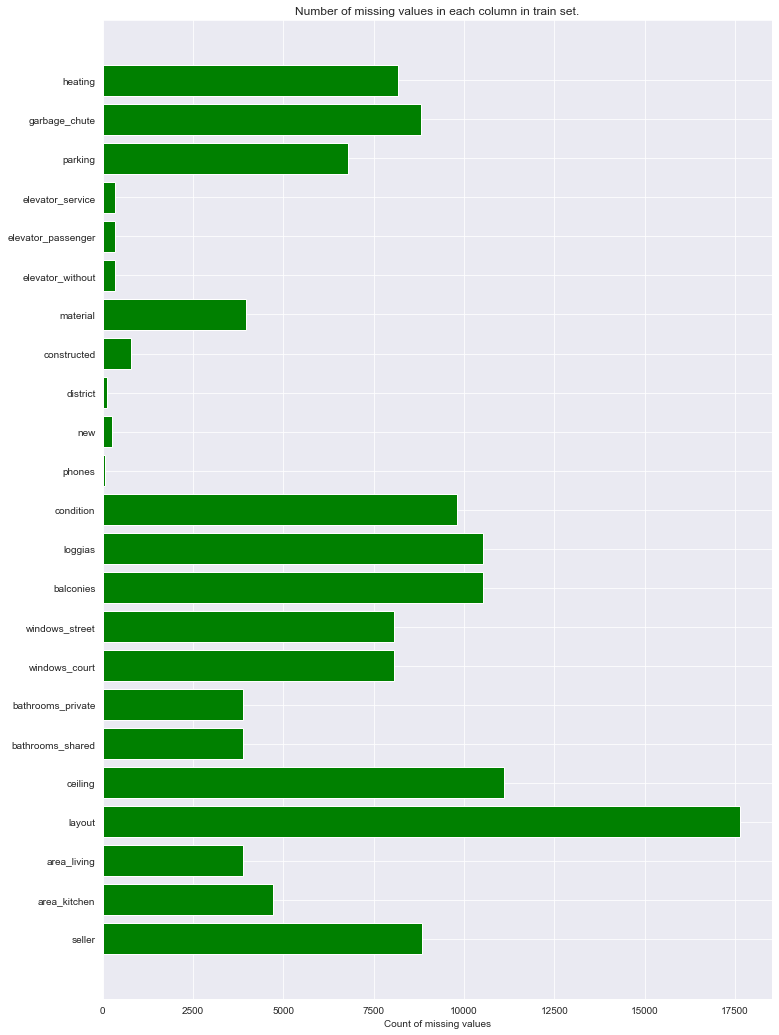

In [156]:
# Plotting missing values in the train set
missing_df = data.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='g')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column in train set.")
plt.show()

Text(0.5, 1.0, 'Number of missing values in each column in test set.')

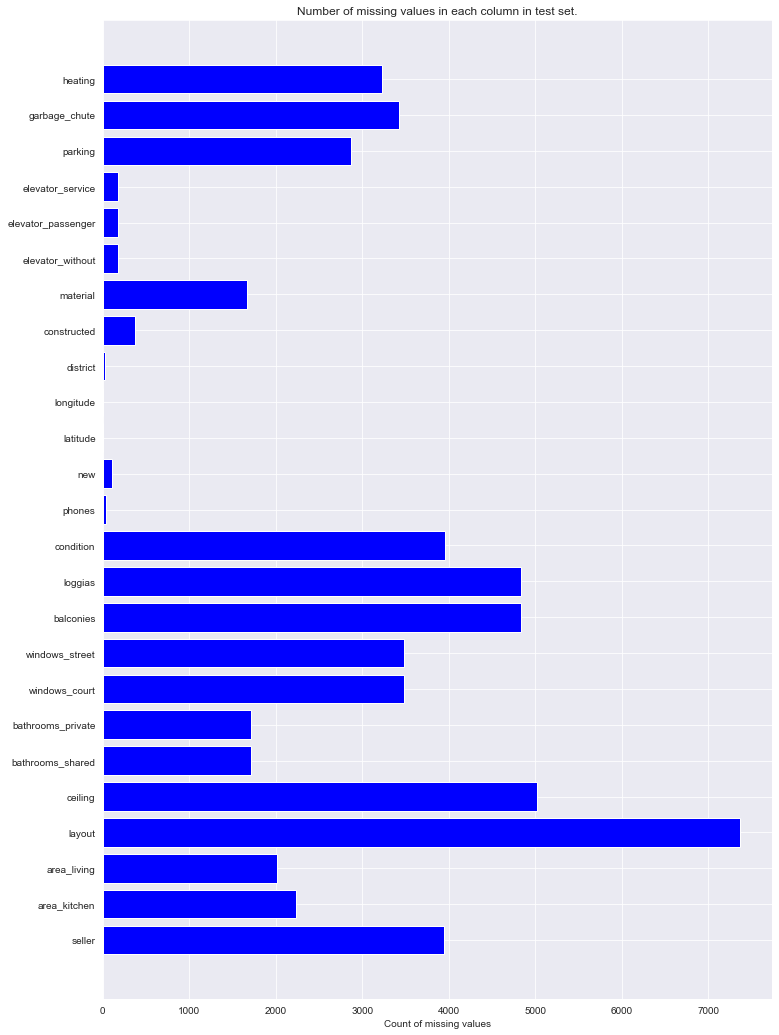

In [157]:
# Plotting missing values in the test set.add
missing_df = data_test.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
ind = np.arange(missing_df.shape[0])
width = 0.9
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color='b')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column in test set.")

We observe that some data seems to be missing in gropus. Foe example, the features related to `windows` seem to either be missing or not (at the same time). This can easily be checked:

In [158]:
# Check if windows_court and windows_street are always simultaneously NAN or not.
all_data.loc[ ~all_data.windows_court.isna(), 'windows_street'].isna().any()

False

The same can be checked for `balconies` and `loggias`, features related to `elevator` and features related to `bathrooms`. This tells us something about how the data was generated, and could come in hand for our feature engineering.

# A Simple LightGBM Model

We create a simple LightGBM model in order to get a better understanding of the relative importance of the features. We use LightGBM because it handles NaN-values. Note that we train on the log of the price, because otherwise the model sometimes predicts negative house prices.

In [159]:
X = data[NUMERIC_FEAT + CATEORICAL_FEAT].copy()
y = data.price.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, shuffle = True, random_state = SEED, stratify = round(np.log(y)))

In [160]:
lgb_mod = lgb.LGBMRegressor(
    num_leaves=10,
    max_depth=5, 
    random_state=42, 
    silent=True, 
    metric='mse',
    n_jobs=4, 
    n_estimators=4000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.005
)

lgb_mod.fit(X_train, np.log(y_train))

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.95,
              importance_type='split', learning_rate=0.005, max_depth=5,
              metric='mse', min_child_samples=20, min_child_weight=0.001,
              min_split_gain=0.0, n_estimators=4000, n_jobs=4, num_leaves=10,
              objective=None, random_state=42, reg_alpha=0.0, reg_lambda=0.0,
              silent=True, subsample=0.9, subsample_for_bin=200000,
              subsample_freq=0)

In [161]:
lgb_preds = np.exp(lgb_mod.predict(X_test))
rmsle(y_test, lgb_preds)

0.18380436132676814

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

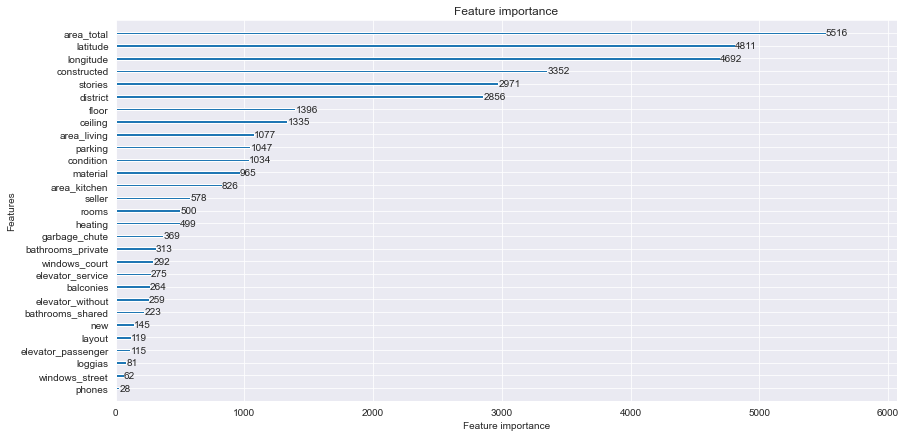

In [162]:
plt.rcParams["figure.figsize"] = (14, 7)
lgb.plot_importance(lgb_mod)

We clearly see that `area_total` is the most important feature, followed by `latitude`and `longitude`. This is in line with what we would expect. Next we consider how the residuals are distributed accross Moscow.

In [164]:
residuals = np.abs(y_test - lgb_preds).rename('residuals')
res_df = pd.concat([X_test[['longitude', 'latitude']], residuals], axis = 1)

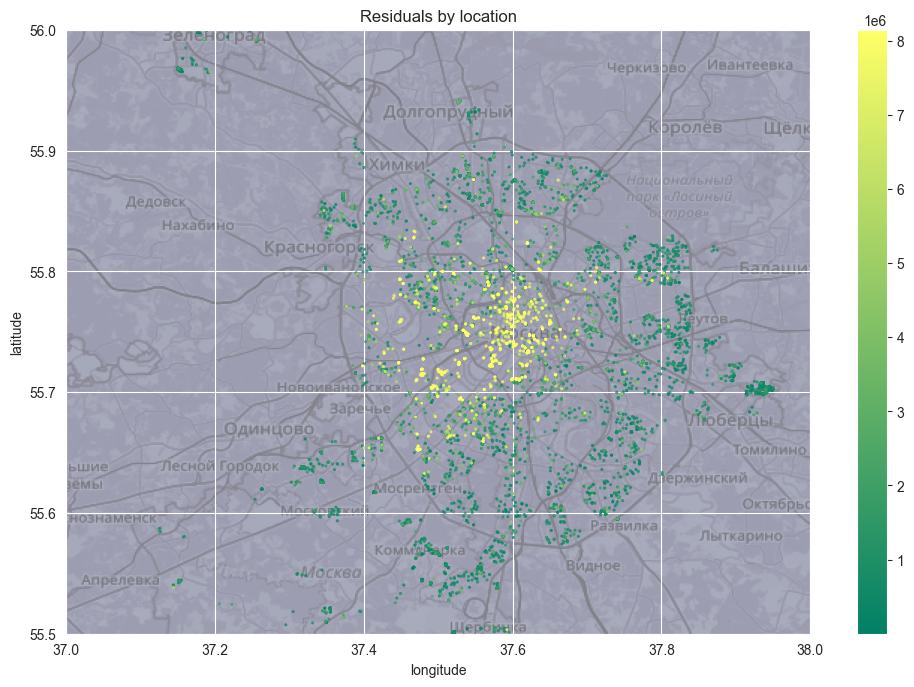

In [165]:
# Plot residuals. Code largely borrow from lecturer.

def plot_map(data, ax=None, s=5, a=0.75, q_lo=0.0, q_hi=0.9, cmap='summer', column='residuals', title='Residuals by location'):
    data = data[['latitude', 'longitude', column]].sort_values(by=column, ascending=True)
    backdrop = plt.imread('resources/data/moscow.png')
    backdrop = np.einsum('hwc, c -> hw', backdrop, [0, 1, 0, 0]) ** 2
    if ax is None:
        plt.figure(figsize=(12, 8), dpi=100)
        ax = plt.gca()
    discrete = data[column].nunique() <= 20
    if not discrete:
        lo, hi = data[column].quantile([q_lo, q_hi])
        hue_norm = plt.Normalize(lo, hi)
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(lo, hi))
        sm.set_array([])
    else:
        hue_norm = None 
    ax.imshow(backdrop, alpha=0.5, extent=[37, 38, 55.5, 56], aspect='auto', cmap='bone', norm=plt.Normalize(0.0, 2))
    sns.scatterplot(x='longitude', y='latitude', hue=data[column].tolist(), ax=ax, s=s, alpha=a, palette=cmap,linewidth=0, hue_norm=hue_norm, data=data)
    ax.set_xlim(37, 38)    # min/max longitude of image 
    ax.set_ylim(55.5, 56)  # min/max latitude of image
    if not discrete:
        ax.legend().remove()
        ax.figure.colorbar(sm)
    ax.set_title(title)
    return ax, hue_norm

plot_map(res_df);

Not surprisingly, the residuals are higher closer to the city center, which is also where the more expensive apartments lie.

# Testing Neural Network with PyTorch

In this section we show some experiments with neural networks. This, however, did not perform well compared to other methods.

### Define NN model

In [166]:
import torch
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linear_stack = nn.Sequential(
            nn.Linear(17, 32),
            nn.Linear(32, 32),
            nn.Linear(32, 16),
            nn.Linear(16, 1),
            nn.ReLU(),
        )

    def forward(self, x):
        res = self.linear_stack(x)
        return res
    
class RMSLELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, pred, actual):
        return torch.sqrt(self.mse(torch.log1p(pred + 1), torch.log1p(actual + 1)))

### Get data used for training/prediction

In [167]:
apartments = pd.read_csv('resources/data/apartments_train.csv')
buildings = pd.read_csv('resources/data/buildings_train.csv')
data = pd.merge(apartments, buildings.set_index('id'), how='left', left_on='building_id', right_index=True)

apartments_test = pd.read_csv('resources/data/apartments_test.csv')
buildings_test = pd.read_csv('resources/data/buildings_test.csv')
data_test = pd.merge(apartments_test, buildings_test.set_index('id'), how='left', left_on='building_id', right_index=True)

In addition to the alredy existing features we create an simple additional feature called "distance" which describes the distance of apartments from the Moscow center

In [168]:
distance = np.sqrt((37.6 - data["longitude"])**2 + (55.75 - data["latitude"])**2)
data["distance"] = distance

We split the data into a training and velidation set so we can monitor our loss against overfitting

In [169]:
import sklearn.model_selection as model_selection
data_train, data_valid = model_selection.train_test_split(data, test_size=0.33, stratify=np.log(data.price).round())

We then choose the variables we want to use in training of the neural network. We choose some of the variables that have a decently high correletion with price. Some of the varaibles are categorical, which will require additional encodig.

In [170]:
nn_train = data_train[['price', 'area_total', 'area_living', 'rooms', 'constructed', 'district', 'distance']].copy()
nn_valid = data_valid[['price', 'area_total', 'area_living', 'rooms', 'constructed', 'district', 'distance']].copy()
nn_train.head()

,price,area_total,area_living,rooms,constructed,district,distance
7808,54500000.0,160.0,NaN,3.0,2004.0,7.0,0.108440
569,13400000.0,60.5,80.0,1.0,2011.0,8.0,0.107201
22919,8800000.0,52.0,32.0,2.0,1973.0,5.0,0.141990
7472,6200000.0,39.0,20.0,1.0,2009.0,2.0,0.188782
20281,7654823.0,53.5,22.8,2.0,2022.0,11.0,0.212419


### Handle NaN values

Pytorch NN training does not handle well NaN values, thus we need to handle them, especially that upon examination of the available data we can see that many variables have significant amount of NaN entries. The simplest way of handling this would be to simply discard the NaN entries, but this may lead to significantly smaller training set, which is not desirable. A common way of handling NaN values is by 'imputation'. There are many ways to impute data, a simple method is to use the mean of the column as the imputation variable, but one can also go as far as creating custom ML models for predicting the missing values.

In [171]:
nn_train['district'].fillna(nn_train['district'].mean(), inplace=True)
nn_valid['district'].fillna(nn_valid['district'].mean(), inplace=True)


# In order to fill the NaN values of area_living, we get the average ratio of living area to total area, then we can multiply this ratio with the area_total of the rows that have NaN area_living
avg_living_ratio = (nn_train['area_living'] / nn_train['area_total']).mean()
nn_train['area_living'].fillna(nn_train['area_total']*avg_living_ratio, inplace=True)
avg_living_ratio = (nn_valid['area_living'] / nn_valid['area_total']).mean()
nn_valid['area_living'].fillna(nn_valid['area_total']*avg_living_ratio, inplace=True)

nn_train['constructed'].fillna(nn_train['constructed'].mean(), inplace=True)
nn_valid['constructed'].fillna(nn_valid['constructed'].mean(), inplace=True)

assert(nn_train.isna().any(axis=1).sum() == 0)
assert(nn_valid.isna().any(axis=1).sum() == 0)

### Encode categorical variables

To encode the categorical variables we use one-hot encoding method, which transforms a variable into a multiple columns, where the number of columns is the number of categories, and each entry sets the column of its category to 1 and 0 for the remaining columns. The variable 'district' has 12 categories encoded as integers from 0 to 11, thus we create a tensor with 12 columns, we use the integer encoding as index into the columns and set 1 for the proper category column for each entry.

In [172]:
#district variable
#there are 12 districts
#Training set
district_tensor_train = torch.zeros(len(nn_train), 12)
idx_train = torch.from_numpy(nn_train["district"].to_numpy())
idx_train = idx_train.type(torch.LongTensor)
row_idx_train = torch.arange(len(district_tensor_train))
district_tensor_train[row_idx_train, idx_train] = 1.0
print(district_tensor_train)

#Validation set
district_tensor_valid = torch.zeros(len(nn_valid), 12)
idx_valid = torch.from_numpy(nn_valid["district"].to_numpy())
idx_valid = idx_valid.type(torch.LongTensor)
row_idx_valid = torch.arange(len(district_tensor_valid))
district_tensor_valid[row_idx_valid, idx_valid] = 1.0
print(district_tensor_valid)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [1., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 1., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 1.,  ..., 0., 0., 0.]])


### Create instance of NN model, and optimizer

We can test how our model behaves with various optimizers and different parameters

In [173]:
model = NeuralNetwork()
#optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, dampening=0.1)
#optimizer = torch.optim.Adagrad(model.parameters(), lr=0.01, lr_decay=0, weight_decay=0, initial_accumulator_value=0, eps=1e-10)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
criterion = RMSLELoss()

### Convert dataframes to pytorch tensors and attach the encoded district variable

Pytorch uses its own defined datatype 'tensors' to perform computation, we need to convert our dataframes to tensors. We also perform minmax scaling on the feature varaibles so that each feature will have equal magnitude and thus will not overwhelm the others. We also split our training data into a train and validation set, so we can verify we we are not overfitting our model.

In [174]:
from sklearn.preprocessing import minmax_scale
import sklearn.model_selection as model_selection

nn_train["area_total"] = minmax_scale(nn_train["area_total"])
nn_train["area_living"] = minmax_scale(nn_train["area_living"])
nn_train["rooms"] = minmax_scale(nn_train["rooms"])
nn_train["constructed"] = minmax_scale(nn_train["constructed"])
nn_train["distance"] = minmax_scale(nn_train["distance"])

nn_valid["area_total"] = minmax_scale(nn_valid["area_total"])
nn_valid["area_living"] = minmax_scale(nn_valid["area_living"])
nn_valid["rooms"] = minmax_scale(nn_valid["rooms"])
nn_valid["constructed"] = minmax_scale(nn_valid["constructed"])
nn_valid["distance"] = minmax_scale(nn_valid["distance"])

X_train = np.array(nn_train[["area_total", "area_living", "rooms", "constructed", "distance"]])
X_train = torch.from_numpy(X_train)
X_train = torch.cat((X_train, district_tensor_train), 1)
X_train = X_train.type(torch.FloatTensor)

X_valid = np.array(nn_valid[["area_total", "area_living", "rooms", "constructed", "distance"]])
X_valid = torch.from_numpy(X_valid)
X_valid = torch.cat((X_valid, district_tensor_valid), 1)
X_valid = X_valid.type(torch.FloatTensor)

print(X_train)
print(X_valid)

Y_train = np.array(nn_train['price'])
Y_train = torch.from_numpy(Y_train)
Y_train = Y_train.type(torch.FloatTensor)

Y_valid = np.array(nn_valid['price'])
Y_valid = torch.from_numpy(Y_valid)
Y_valid = Y_valid.type(torch.FloatTensor)

print(X_train.size())
print(Y_train.size())

print(X_valid.size())
print(Y_valid.size())

tensor([[0.0694, 0.0734, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0236, 0.0668, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0197, 0.0267, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0206, 0.0277, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0211, 0.0306, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0189, 0.0267, 0.4000,  ..., 0.0000, 0.0000, 0.0000]])
tensor([[0.0736, 0.0778, 0.6000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0320, 0.0378, 0.4000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0336, 0.0378, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0707, 0.0518, 0.4000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0269, 0.0376, 0.2000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0378, 0.0420, 0.4000,  ..., 0.0000, 0.0000, 0.0000]])
torch.Size([15600, 17])
torch.Size([15600])
torch.Size([7685, 17])
torch.Size([7685])


## Train the model
We train the model and save the training and validation loss for every 100th epoch to monitor progress

tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)
tensor(15.3570, grad_fn=<SqrtBackward0>)
tensor(15.3545, grad_fn=<SqrtBackward0>)


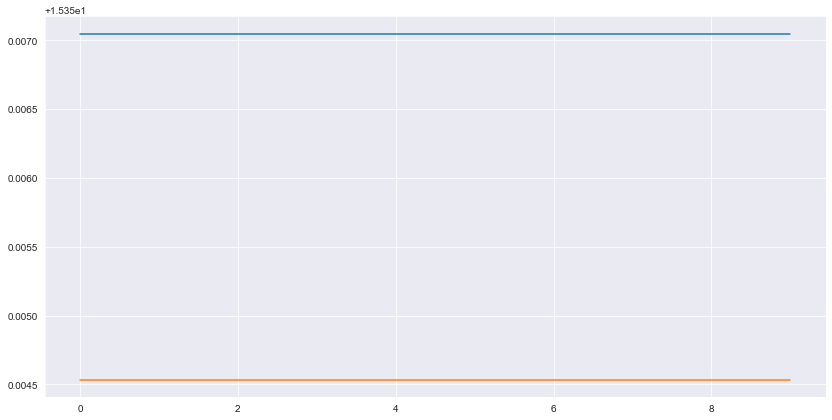

In [175]:
train_history = []
validation_history = []

for i in range(1000):
    pred = model(X_train)
    loss = criterion(torch.exp(pred).flatten(), Y_train)
    if (i % 100) == 0:
        print(loss)
        train_history.append(loss.detach().numpy() )
        val_pred = model(X_valid)
        loss_val = criterion(torch.exp(val_pred).flatten(), Y_valid)
        validation_history.append(loss_val.detach().numpy() )
        print(loss_val)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

x = np.arange(len(train_history))
plt.plot(x, train_history)
plt.plot(x, validation_history)
plt.show()

The performance varied between runs, and we did not pursue this much further.

# Data Cleaning

## Setup

In [176]:
# Use an SQLite database for persistent Optuna storage, replace with `None` to
# use in-memory storage
STORAGE = "sqlite:///resources/vegard_optuna.sqlite"

We reload the datasets in order to avoid conflicts with previous processing in the notebook.

In [177]:
# Read the apartment datasets
apartments_train = pd.read_csv("resources/data/apartments_train.csv").set_index("id")
apartments_train["split"] = "train"
apartments_test = pd.read_csv("resources/data/apartments_test.csv").set_index("id")
apartments_test["split"] = "test"

# Create a DataFrame of all apartments
apartments = pd.concat([apartments_train, apartments_test])

# Read the building datasets
buildings_train = pd.read_csv("resources/data/buildings_train.csv").set_index("id")
buildings_train["split"] = "train"
buildings_test = pd.read_csv("resources/data/buildings_test.csv").set_index("id")
buildings_test["split"] = "test"

# Create a GeoDataFrame of all buildings
buildings = pd.concat([buildings_train, buildings_test])
buildings = gpd.GeoDataFrame(buildings, geometry=gpd.points_from_xy(
    buildings.longitude, buildings.latitude, crs="EPSG:4326"
))

## Incorrectly positioned buildings

In the dataset we discovered buildings with missing or unexpected locations. In this section we try to rectify this in order to improve our models.

### Missing coordinates

In [178]:
# Find all buildings missing coordinates
no_coords = buildings.latitude.isna() | buildings.longitude.isna()
buildings[no_coords][[
    "split", "latitude", "longitude", "district", "street", "address",
    "constructed", "material", "stories"
]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
3803,test,NaN,NaN,NaN,пос. Коммунарка,Москва А101 ЖК,2019.0,2.0,12.0


There's only one building with missing coordinates, and by looking at the address we assume it to be located in Moscow.

In [179]:
# Find other buildings on the same street
street = buildings[~no_coords & (buildings.street == "пос. Коммунарка")]
street[[
    "split", "latitude", "longitude", "district", "street", "address",
    "constructed", "material", "stories"
]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
2036,train,55.569133,37.474408,11.0,пос. Коммунарка,22,2013.0,NaN,14.0
2461,train,55.571632,37.473492,11.0,пос. Коммунарка,20,2011.0,NaN,17.0
6375,train,55.567285,37.477929,11.0,пос. Коммунарка,17,1994.0,3.0,12.0
6280,train,55.572986,37.475189,11.0,пос. Коммунарка,4,1963.0,4.0,5.0
8577,train,55.570843,37.473635,11.0,пос. Коммунарка,20А,2012.0,NaN,17.0
6200,test,55.560891,37.473761,11.0,пос. Коммунарка,101,2020.0,0.0,16.0


Checking the rest of our data we find multiple buildings on the same street. There is even another building in the test dataset with an address number containing 101, though we do not assume these to be the same building due to differing values in the other columns of the dataset.

We set the missing location information be taking the median location of each known building on the same street and the most common district number (only 11).

In [180]:
# Set the location and district for the building with missing coordinates
buildings.loc[no_coords, "latitude"] = street.latitude.mean()
buildings.loc[no_coords, "longitude"] = street.longitude.mean()
buildings.loc[no_coords, "district"] = street.district.mode()[0]

print("There are now", (buildings.latitude.isna() | buildings.longitude.isna()).sum(), "buildings with missing coordinates.")

There are now 0 buildings with missing coordinates.


### Buildings with coordinates outside of Moscow

In [181]:
# The coordinates of the southwest and northeast corners of a rectangle approximately encompassing Moscow
MOSCOW_SW_LAT = 55.101131
MOSCOW_SW_LON = 36.754394
MOSCOW_NE_LAT = 56.117476
MOSCOW_NE_LON = 38.218283

In [182]:
# Find all buildings with coordinates outside of Moscow
outside = (((buildings.latitude < MOSCOW_SW_LAT) | (buildings.latitude > MOSCOW_NE_LAT))
          & ((buildings.longitude < MOSCOW_SW_LON) | (buildings.longitude > MOSCOW_NE_LON)))
buildings[outside][[
    "split", "latitude", "longitude", "district", "street", "address",
    "constructed", "material", "stories"
]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
5667,test,43.352968,132.759204,NaN,улица Центральная,48,NaN,NaN,2.0
4412,test,17.141734,-61.790500,NaN,Бунинские Луга ЖК,к2/2/2,2021.0,NaN,9.0
4202,test,42.914700,74.517184,NaN,улица 1-я Линия,57,2016.0,NaN,3.0
8811,test,43.353545,132.768097,NaN,улица Центральная,75,2007.0,NaN,5.0
4636,test,17.141734,-61.790500,NaN,Бунинские Луга ЖК,к2/2/1,2021.0,3.0,17.0


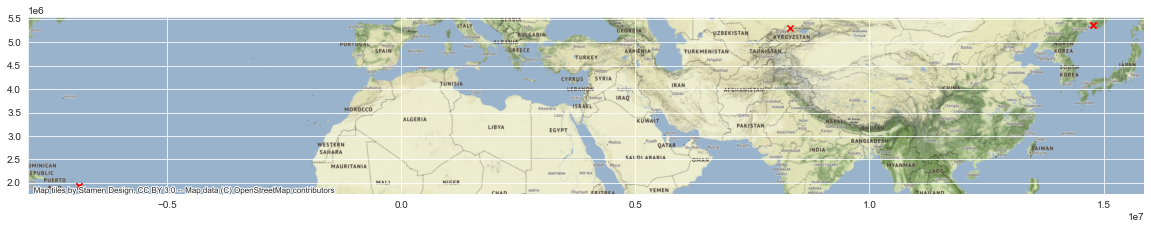

In [183]:
# Plot the buildings outside of Moscow on a map
ax = buildings[outside].to_crs(epsg=3857).plot(figsize=(20, 10), marker="x", color="r")
cx.add_basemap(ax)

We note that all the buildings with missing coordinates are in the test set and have seemingly Russian name, indicating that these may be data entry errors and the buildings may actually be located inside Moscow.

In [184]:
# Find the number of buildings in the dataset on the same street
streets = buildings[outside].street.unique()
pd.DataFrame(
    index=streets,
    data={
        "test": map(
            lambda street: len(buildings[
                ~outside
                & (buildings.split == "test")
                & (buildings.street == street)
            ]),
            streets
        ),
        "train": map(
            lambda street: len(buildings[
                ~outside
                & (buildings.split == "train")
                & (buildings.street == street)
            ]),
            streets
        ),
    },
)

,test,train
улица Центральная,8,16
Бунинские Луга ЖК,1,8
улица 1-я Линия,0,0


Looking at the number of buildings on the same street in our dataset, we find that two of the streets have multiple other buildings. For these we use the mean location of the buildings on that street and the most common district. For the remaining street without any other buildings we place it at the mean location of all known buildings inside Moscow.

In [185]:
# Set the location (and district) of the buildings with coordinates outside of Moscow
for idx, building in buildings[outside].iterrows():
    street = buildings[~outside & (buildings.street == building.street)]
    if len(street):
        buildings.loc[idx, "latitude"] = street.latitude.mean()
        buildings.loc[idx, "longitude"] = street.longitude.mean()
        buildings.loc[idx, "district"] = street.district.mode()[0]
    else:
        buildings.loc[idx, "latitude"] = buildings[~outside].latitude.mean()
        buildings.loc[idx, "longitude"] = buildings[~outside].longitude.mean()

print("There are now", (((buildings.latitude < MOSCOW_SW_LAT) | (buildings.latitude > MOSCOW_NE_LAT)) & ((buildings.longitude < MOSCOW_SW_LON) | (buildings.longitude > MOSCOW_NE_LON))).sum(), "buildings outside of Moscow")

There are now 0 buildings outside of Moscow


### Missing `district`

In [186]:
# Find all buildings missing a district
no_district = buildings.district.isna()
buildings[no_district][["split", "latitude", "longitude", "district", "street", "address", "constructed", "material", "stories"]]

,split,latitude,longitude,district,street,address,constructed,material,stories
id,,,,,,,,,
4162,train,55.595160,37.741109,NaN,23-й км,5к1,2021.0,3.0,9.0
1647,test,55.595160,37.741109,NaN,23-й км,7к1,2018.0,NaN,25.0
6403,test,55.595160,37.741109,NaN,23-й км,11к1,2019.0,NaN,16.0
7317,test,55.583551,37.711356,NaN,25-й км,вл1с1,NaN,NaN,13.0
2265,test,55.595160,37.741109,NaN,23-й км,13к2,2018.0,NaN,25.0
926,test,55.921627,37.781578,NaN,В мкр,37,1989.0,2.0,16.0
6879,test,55.932127,37.793705,NaN,В мкр,30,1975.0,2.0,9.0
4202,test,55.727684,37.592893,NaN,улица 1-я Линия,57,2016.0,NaN,3.0
183,test,55.595160,37.741109,NaN,23-й км,11к2,2019.0,NaN,25.0


Since all buildings now have approximate coordinates inside of Moscow, we copy the district from the closest building (Manhattan distance).

In [187]:
# For each building with district missing, copy the district from the closest building
# Closest here is the smallest coordinate difference
districts = buildings.loc[no_district].apply(
    lambda b: buildings.loc[
        (buildings[~no_district][["latitude", "longitude"]] - b[["latitude", "longitude"]]).abs().sum(axis=1).idxmin()
    ].district,
    axis=1
)
districts.rename("district", inplace=True)
buildings.update(districts)

print("There are now", buildings.district.isna().sum(), "buildings with district missing")

There are now 0 buildings with district missing


## Nearest POIs

The distance to nearby points of interest (POI) may affect the price of an apartment. To capture this effect, we compute the distance to nearby metro stations, parks and gardens, and public squares.

Distance is calculated using the haversine formula and is given in meters.

In [188]:
# The Earth's radius in meters
EARTH_RADIUS = 6371000

# Create columns for coordinates given in radians to avoid having to recalculate
buildings["lat_rad"] = np.radians(buildings.latitude)
buildings["lon_rad"] = np.radians(buildings.longitude)

### Metro Stations

Station location data downloaded from [_List of Moscow Metro stations_](https://en.wikipedia.org/wiki/List_of_Moscow_Metro_stations) on Wikipedia.

In [189]:
# Read the metro station location data into a DataFrame
stations = gpd.read_file("resources/metro_stations.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# Create columns for the coordinates given in radians
stations["lat_rad"] = np.radians(stations.geometry.y)
stations["lon_rad"] = np.radians(stations.geometry.x)

stations

,name,geometry,lat_rad,lon_rad
0,Bulvar Rokossovskogo (Sokolnicheskaya line),POINT Z (37.73420 55.81480 0.00000),0.974152,0.658586
1,Cherkizovskaya,POINT Z (37.74480 55.80380 0.00000),0.973960,0.658771
2,Preobrazhenskaya Ploshchad,POINT Z (37.71510 55.79630 0.00000),0.973829,0.658253
3,Sokolniki,POINT Z (37.68020 55.78880 0.00000),0.973698,0.657644
4,Krasnoselskaya,POINT Z (37.66730 55.78010 0.00000),0.973546,0.657418
...,...,...,...,...
263,Yugo-Vostochnaya,POINT Z (37.81901 55.70497 0.00000),0.972235,0.660066
264,Kosino,POINT Z (37.85110 55.70330 0.00000),0.972206,0.660626
265,Ulitsa Dmitriyevskogo,POINT Z (37.87920 55.71000 0.00000),0.972323,0.661117
266,Lukhmanovskaya,POINT Z (37.90040 55.70850 0.00000),0.972297,0.661487


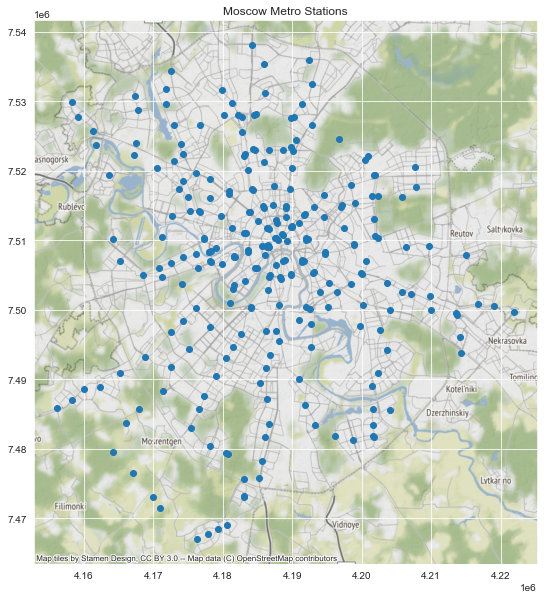

In [190]:
# Plot the location of each metro station on a map
ax = stations.to_crs(epsg=3857).plot(figsize=(10, 10))
ax.set_title("Moscow Metro Stations")
cx.add_basemap(ax)

Add a `metro_distance` feature to `buildings` for the distance to the nearest metro station in meters.

In [191]:
# Calculate the distance to the nearest metro station for each building using
# the haversine formula with the Earth's radius as given above
metro_dist =  buildings.apply(
    lambda row:
            2 * EARTH_RADIUS
            * np.arcsin(
                np.sqrt(
                    np.sin((stations.lat_rad - row.lat_rad) / 2) ** 2
                    + np.cos(row.lat_rad)
                    * np.cos(stations.lat_rad)
                    * np.sin((stations.lon_rad - row.lon_rad) / 2) ** 2
            )), axis=1
)

buildings["metro_distance"] = np.min(metro_dist, axis = 1)

# Calculate the number of 'close' metro stations.
buildings['metro_close'] = np.sum(metro_dist < 1000, axis = 1)

### Parks and Gardens

Park and garden data downloaded from [_Category:Parks and gardens in Moscow_](https://en.wikipedia.org/wiki/Category:Parks_and_gardens_in_Moscow) on Wikipedia.

In [192]:
# Read park and garden location data
parks = gpd.read_file("resources/parks_and_gardens.kml", driver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# Create columns for coordinates given in radians
parks["lon_rad"] = np.radians(parks.geometry.x)
parks["lat_rad"] = np.radians(parks.geometry.y)

parks

,name,geometry,lon_rad,lat_rad
0,Alexander Garden,POINT Z (37.61389 55.75250 0.00000),0.656486,0.973065
1,Bitsa Park,POINT Z (37.56700 55.61750 0.00000),0.655668,0.970708
2,Clean Ponds,POINT Z (37.64472 55.76083 0.00000),0.657024,0.973210
3,Fallen Monument Park,POINT Z (37.60528 55.73278 0.00000),0.656336,0.972720
4,Gorky Park (Moscow),POINT Z (37.60000 55.72833 0.00000),0.656244,0.972643
5,Izmaylovo Estate,POINT Z (37.76222 55.79167 0.00000),0.659075,0.973748
6,Izmaylovo Estate,POINT Z (37.76917 55.80111 0.00000),0.659196,0.973913
7,Izmaylovo Estate,POINT Z (37.75028 55.79944 0.00000),0.658867,0.973884
8,Izmaylovo Estate,POINT Z (37.78611 55.77444 0.00000),0.659492,0.973448
9,Izmaylovo Estate,POINT Z (37.81722 55.77194 0.00000),0.660035,0.973404


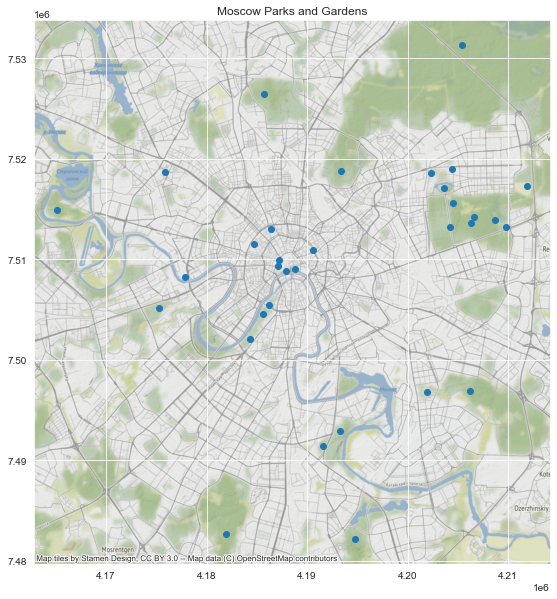

In [193]:
# Plot the location of each park and garden on a map
ax = parks.to_crs(epsg=3857).plot(figsize=(10, 10))
ax.set_title("Moscow Parks and Gardens")
cx.add_basemap(ax)

Add a `park_distance` feature to `buildings` for the distance to the nearest park or garden in meters.

In [194]:
# Calculate the distance to the nearest park or garden for each building using
# the haversine formula with the Earth's radius as given above
park_dist = buildings.apply(
    lambda row:
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((parks.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(parks.lat_rad)
                * np.sin((parks.lon_rad - row.lon_rad) / 2) ** 2
            )
        ), axis = 1
    )

buildings["park_distance"] = np.min(park_dist, axis = 1)

# Calculate number of 'close' parks to the house.
buildings['park_close']  = np.sum(park_dist < 2000, axis = 1)


### Squares

Square data downloaded from [_Category:Squares in Moscow_](https://en.wikipedia.org/wiki/Category:Squares_in_Moscow) on Wikipedia.

In [195]:
# Read square location data
squares = gpd.read_file("resources/squares.kml", dirver="KML").drop(columns=["Description"]).rename(columns={"Name": "name"})

# Create columns for coordinates given in radians
squares["lon_rad"] = np.radians(squares.geometry.x)
squares["lat_rad"] = np.radians(squares.geometry.y)

squares

,name,geometry,lon_rad,lat_rad
0,Arbatskaya Square,POINT Z (37.60110 55.75190 0.00000),0.656263,0.973054
1,Bolotnaya Square,POINT Z (37.61750 55.74500 0.00000),0.656549,0.972934
2,"Cathedral Square, Moscow",POINT Z (37.61750 55.75056 0.00000),0.656549,0.973031
3,Ivanovskaya Square,POINT Z (37.61880 55.75160 0.00000),0.656572,0.973049
4,Josip Broz Tito Square,POINT Z (37.56333 55.67806 0.00000),0.655604,0.971765
5,Komsomolskaya Square (Moscow),POINT Z (37.65417 55.77500 0.00000),0.657189,0.973457
6,Krestyanskaya Zastava Square,POINT Z (37.66920 55.73250 0.00000),0.657452,0.972716
7,Lubyanka Square,POINT Z (37.62694 55.75944 0.00000),0.656714,0.973186
8,"Manezhnaya Square, Moscow",POINT Z (37.61472 55.75583 0.00000),0.656501,0.973123
9,Pushkinskaya Square,POINT Z (36.62250 55.76556 0.00000),0.639183,0.973293


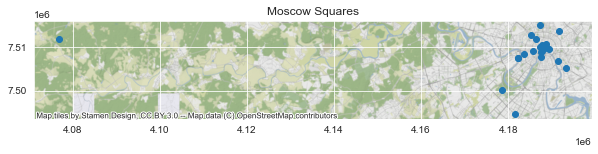

In [196]:
# Plot the location of each square on a map
ax = squares.to_crs(epsg=3857).plot(figsize=(10, 10))
ax.set_title("Moscow Squares")
cx.add_basemap(ax)

Add a `square_distance` feature to `buildings` for the distance to the nearest square in meters.

In [197]:
# Calculate the distance to the nearest square for each building using the
# haversine formula with the Earth's radius as given above
square_dist = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((squares.lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(squares.lat_rad)
                * np.sin((squares.lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

buildings['square_distance'] = np.min(square_dist, axis = 1)

# Calculate number of 'close' squares
buildings['square_close']  = np.sum(square_dist < 3000, axis = 1)

## Rich and Prestigous Districts in Moscow
In addition to metros, parks and squares, we include the distances to some especially rich and prestigous neighbourhoods in Moscow, in the hopes that this will help with the prediction error on the most expensive apartments. The districts are gathered from [this article](https://www.rbth.com/travel/332318-expensive-rich-districts-moscow) in _Russia Beyond_, and the position of each district is captured by manually sampling a reasonable position from Google Maps.

In [198]:
rublevka_lat = 55.73870
rublevka_lon = 37.25904
rublevka_lat_rad = np.radians(rublevka_lat)
rublevka_lon_rad = np.radians(rublevka_lon)

buildings['rublevka_dist'] = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((rublevka_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(rublevka_lat_rad)
                * np.sin((rublevka_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [199]:
ostoz_lat = 55.74041592186014
ostoz_lon = 37.59606083068356
ostoz_lat_rad = np.radians(ostoz_lat)
ostoz_lon_rad = np.radians(ostoz_lon)

buildings['ostoz_dist'] = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((ostoz_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(ostoz_lat_rad)
                * np.sin((ostoz_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [200]:
khamo_lat = 55.733078399352074
khamo_lon = 37.574861386328806
khamo_lat_rad = np.radians(khamo_lat)
khamo_lon_rad = np.radians(khamo_lon)

buildings['khamo_dist'] = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((khamo_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(khamo_lat_rad)
                * np.sin((khamo_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [201]:
yaki_lat = 55.732884073626586
yaki_lon = 37.610828401028435
yaki_lat_rad = np.radians(yaki_lat)
yaki_lon_rad = np.radians(yaki_lon)

buildings['yaki_dist'] = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((yaki_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(yaki_lat_rad)
                * np.sin((yaki_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [202]:
arbat_lat = 55.751646651040474
arbat_lon = 37.601199713824386
arbat_lat_rad = np.radians(arbat_lat)
arbat_lon_rad = np.radians(arbat_lon)

buildings['arbat_dist'] = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((arbat_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(arbat_lat_rad)
                * np.sin((arbat_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [203]:
pres_lat = 55.7638390539512
pres_lon = 37.559469484210624
pres_lat_rad = np.radians(pres_lat)
pres_lon_rad = np.radians(pres_lon)

buildings['pres_dist'] = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((pres_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(pres_lat_rad)
                * np.sin((pres_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

In [204]:
tver_lat = 55.76960731290398
tver_lon = 37.608153625557165
tver_lat_rad = np.radians(tver_lat)
tver_lon_rad = np.radians(tver_lon)

buildings['tver_dist'] = buildings.apply(
    lambda row: 
        2
        * EARTH_RADIUS
        * np.arcsin(
            np.sqrt(
                np.sin((tver_lat_rad - row.lat_rad) / 2) ** 2
                + np.cos(row.lat_rad)
                * np.cos(tver_lat_rad)
                * np.sin((tver_lon_rad - row.lon_rad) / 2) ** 2
            )
        ), 
    axis=1
)

### Cleanup

Drop temporary columns and variables.

In [205]:
del stations, parks, squares

buildings.drop(columns=["lat_rad", "lon_rad"], inplace=True)

## Estimate construction year

In the dataset there are multiple buildings missing a contruction year. This section tries to guess the construction year using other buildings in the same district and the same street. The guesses are put in a new `contructed_fix` feature, leaving the original `constructed` feature untouched.

In [206]:
print("There are", buildings.constructed.isna().sum(), "buildings missing a construction year")

There are 708 buildings missing a construction year


In [207]:
# Find the mean and median construction year for each district
district_constructed_mean = buildings.groupby("district").constructed.mean().round()
district_constructed_median = buildings.groupby("district").constructed.median().round()

In [208]:
# Find the mean and median construction year for each street
street_constructed_mean = buildings.groupby("street").constructed.mean().round().dropna()
street_constructed_median = buildings.groupby("street").constructed.median().round().dropna()

In [209]:
# Print the error of the different estimation techniques compared to the known values
idx = ~buildings.constructed.isna()
pd.DataFrame.from_dict({
    "District Mean": mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].district.map(lambda d: district_constructed_mean[d]),
    ),
    "District Median": mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].district.map(lambda d: district_constructed_median[d]),
    ),
    "Street Mean": mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].street.map(lambda s: street_constructed_mean[s]),
    ),
    "Street Median": mean_absolute_error(
        buildings[idx].constructed,
        buildings[idx].street.map(lambda s: street_constructed_median[s]),
    ),
}, orient="index", columns=["Mean Absolute Error"])

,Mean Absolute Error
District Mean,18.276681
District Median,17.787553
Street Mean,10.048702
Street Median,8.980142


The best estimator seems to be the median construction year of all the buildings on the same street. Unfortunately, there are some streets where none of the buildings have known construction dates, for these we fall back to the median construction year of the district.

In [210]:
# Add estimates for the buildings with missing constructions years
buildings['constructed_fix'] = buildings.constructed
buildings.loc[~idx, "constructed_fix"] = buildings[~idx].apply(
    lambda b: street_constructed_median[b.street]
              if b.street in street_constructed_median
              else district_constructed_median[b.district],
    axis=1
)
print("There are now", buildings.constructed_fix.isna().sum(), "buildings with a missing construction year")

There are now 0 buildings with a missing construction year


## Ceiling

In the datasets we find a number of apartments with a suspiciously high ceiling. We try to fix this and put the results into a new `ceiling_fix` feature, leaving the original `ceiling` feature untouched.

In [211]:
idx = apartments.ceiling > 50
pd.DataFrame(apartments.ceiling[idx].describe())

,ceiling
count,31.000000
mean,294.838710
std,27.793401
min,250.000000
25%,267.500000
50%,300.000000
75%,317.500000
max,350.000000


Looking at `apartments` we see 31 with a ceiling higher than 50m. Inspecting the data, we find it likely that these are data entry error, i.e. that the data has been entered in centimeters instead of meters.

In [212]:
# Create a new feature, `ceiling_fix`, where this has been corrected
apartments["ceiling_fix"] = apartments.ceiling
apartments.loc[idx, "ceiling_fix"] = apartments.ceiling[idx] / 100

## Merge

Merges `apartments` and `buildings` into a single dataframe named `data`.

In [213]:
# Merge while making sure we're keeping the correct index
data = apartments.reset_index().merge(
    buildings, how="left", left_on=["building_id", "split"], right_on=["id", "split"]
).set_index("id")

## Some Simple Feature Engineering

Recall that we above noticed that some features are missing in groups. We there decided to combine `balconies` and `loggias` into one feature, `ballog`, and likewise for the bathrooms-features. See below:

In [214]:
data["ballog"] = data.balconies + data.loggias

In [215]:
data["bathrooms_total"] = data.bathrooms_private + data.bathrooms_shared

Next, we create a feature for the average price per sqm in each district, since this might be a good measure of the quality of the buildings in that district.

In [216]:
data['price_per_sqm'] = data.price/data.area_total
avg_price_per_sqm = data.groupby('district').agg('mean')['price_per_sqm']

distr_avg = np.empty(data.shape[0])
for i in range(data.shape[0]):
    distr_avg[i] = avg_price_per_sqm[int(data.district[i])]
data['distr_avg'] = distr_avg

We create a feature for the area per room:

In [217]:
data['log_area_per_room'] = np.log(data.area_total / data.rooms)
data['price'].corr(data.log_area_per_room)

0.4086217760032586

We note that the correlation with the response is reasonably high.

## Scaling the Response and the most important feature
We calculate the log of the price per square meter, since this might be reasonable to use as a response. We also scale the most correlated feature with the response, namely `area_total`.

In [218]:
data["log_price_per_sqm"] = np.log(data.price / data.area_total)

In [219]:
data["log_area_total"] = np.log(data.area_total)

## Split

Splits the training and testing sets into their own dataframes.

In [220]:
data_train = data[data.split == "train"].copy()
data_test = data[data.split == "test"].copy()

# LightGBM-F4LC

First, we try a LightGBM model on the dataset prepared in the previous section. The hyperparameters for the model will be tuned using Optuna.

In [221]:
LIGHTGBM_F4LC_FEATURES = [
    "latitude", "longitude", "district", "constructed_fix", "log_area_total",
    "rooms", "ballog", "metro_distance", "park_distance", "square_distance",
    "material", "condition", "heating", "stories", "floor", "ceiling_fix",
    "bathrooms_total", "new",
]
LIGHTGBM_F4LC_CATEGORICAL_FEATURES = [
    "district", "material", "condition", "heating", "new",
]

In [222]:
def lightgbm_f4lc_objective(trial):
    params = {
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        "subsample": trial.suggest_categorical("subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03]),
        "max_depth": trial.suggest_int("max_depth", 1, 250),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth": trial.suggest_int("cat_smooth", 3, 60),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = lgb.LGBMRegressor(random_state=42, metric="rmse", n_estimators=5000, n_jobs=3, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[LIGHTGBM_F4LC_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(
            train[LIGHTGBM_F4LC_FEATURES],
            train.log_price_per_sqm,
            categorical_feature=LIGHTGBM_F4LC_CATEGORICAL_FEATURES
        )

        predictions = np.exp(model.predict(test[LIGHTGBM_F4LC_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

We try to load the Optuna study from storage. If not such study is found, we do some trials. By default, this code section runs 10 trials. While developing the models for submission to Kaggle we ran 100 trials.

In [223]:
lightgbm_f4lc_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="LightGBM-F4LC",
    direction="minimize",
    load_if_exists=True
)

if not lightgbm_f4lc_study.trials:
    lightgbm_f4lc_study.optimize(lightgbm_f4lc_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-18 19:28:21,561] Using an existing study with name 'LightGBM-F4LC' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [224]:
pd.DataFrame.from_dict({
    "Number of completed trials": (lightgbm_f4lc_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": lightgbm_f4lc_study.best_trial.number,
    "Best value": lightgbm_f4lc_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.00000
Best trial,86.00000
Best value,0.11871


In [225]:
pd.DataFrame.from_dict(lightgbm_f4lc_study.best_params, orient="index", columns=["Value"])

,Value
cat_smooth,56.000000
colsample_bytree,0.600000
learning_rate,0.030000
max_depth,121.000000
min_child_samples,1.000000
num_leaves,515.000000
reg_alpha,0.130203
reg_lambda,1.293769
subsample,1.000000


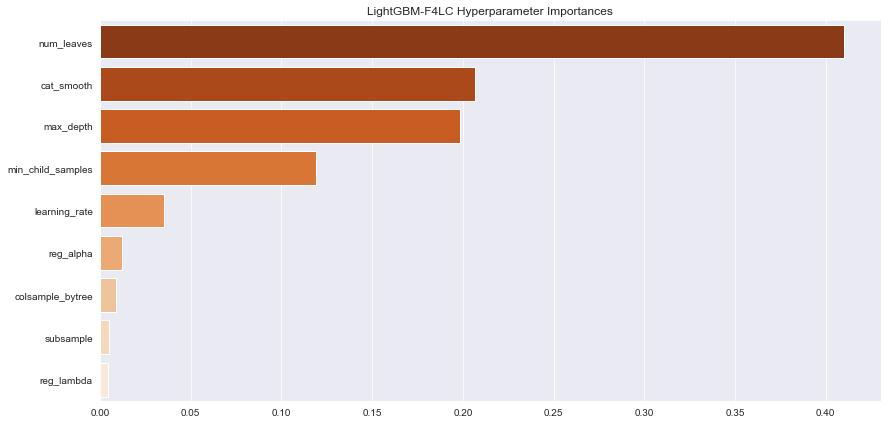

In [226]:
plot_hyperparameter_importances(lightgbm_f4lc_study)

Train a LightGBM model on all training data using the tuned hyperparamters in order to make predictions on the testing set.

In [227]:
lightgbm_f4lc_model = lgb.LGBMRegressor(metric="rmse", n_estimators=5000, random_state=42, **lightgbm_f4lc_study.best_params)

lightgbm_f4lc_model.fit(data_train[LIGHTGBM_F4LC_FEATURES], data_train.log_price_per_sqm, categorical_feature=LIGHTGBM_F4LC_CATEGORICAL_FEATURES)

LGBMRegressor(boosting_type='gbdt', cat_smooth=56, class_weight=None,
              colsample_bytree=0.6, importance_type='split', learning_rate=0.03,
              max_depth=121, metric='rmse', min_child_samples=1,
              min_child_weight=0.001, min_split_gain=0.0, n_estimators=5000,
              n_jobs=-1, num_leaves=515, objective=None, random_state=42,
              reg_alpha=0.13020331134351731, reg_lambda=1.2937692395596345,
              silent=True, subsample=1.0, subsample_for_bin=200000,
              subsample_freq=0)

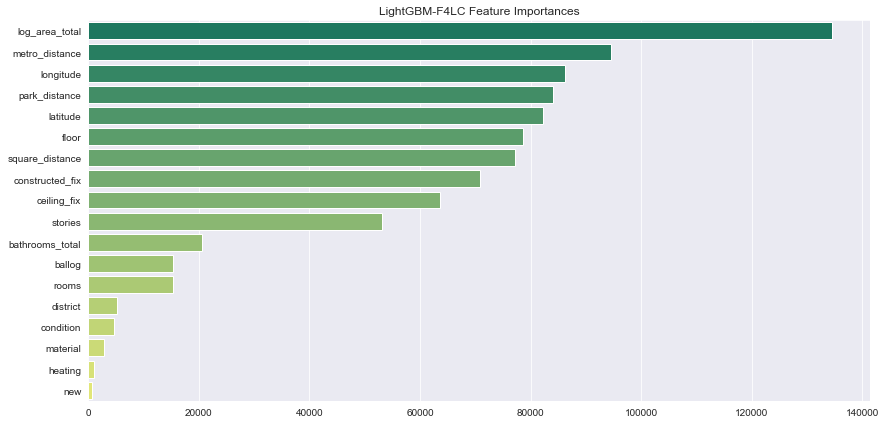

In [228]:
plot_feature_importances(LIGHTGBM_F4LC_FEATURES, lightgbm_f4lc_model.feature_importances_, "LightGBM-F4LC")

In [229]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
lightgbm_f4lc_prediction = np.exp(lightgbm_f4lc_model.predict(data_test[LIGHTGBM_F4LC_FEATURES])) * data_test.area_total
#lightgbm_f4lc_prediction.rename("price_prediction").to_csv("submissions/lightgbm_f4lc.csv", index_label="id")

# XGBoost-P2

In [230]:
XGBOOST_P2_FEATURES = [
    "latitude", "longitude", "district", "constructed_fix", "area_total", "rooms",
    "ballog", "metro_distance", "park_distance", "square_distance", "material",
    "condition", "heating", "stories", "floor", "ceiling", "bathrooms_total",
    "new",
]

In [231]:
def xgboost_p2_objective(trial):
    params = {
        "booster": trial.suggest_categorical("booster", ["gbtree", "dart"]),
        "eta": trial.suggest_loguniform("eta", 0.001, 0.5),
        "gamma": trial.suggest_loguniform("gamma", 0.00001, 10.0),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 1000),
        "subsample": trial.suggest_loguniform("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.1, 1.0),
        "lambda": trial.suggest_loguniform("lambda", 0.00001, 10.0),
        "alpha": trial.suggest_loguniform("alpha", 0.00001, 10.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, nthread=3, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[XGBOOST_P2_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(train[XGBOOST_P2_FEATURES], train.log_price_per_sqm)

        predictions = np.exp(model.predict(test[XGBOOST_P2_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

We try to load the Optuna study from storage. If not such study is found, we do some trials. By default, this code section runs 10 trials. While developing the models for submission to Kaggle we ran 100 trials.

In [232]:
xgboost_p2_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="XGBoost-P2",
    direction="minimize",
    load_if_exists=True
)

if not xgboost_p2_study.trials:
    xgboost_p2_study.optimize(xgboost_p2_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-18 19:28:54,980] Using an existing study with name 'XGBoost-P2' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [233]:
pd.DataFrame.from_dict({
    "Number of completed trials": (xgboost_p2_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": xgboost_p2_study.best_trial.number,
    "Best value": xgboost_p2_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,89.000000
Best value,0.121779


In [234]:
pd.DataFrame.from_dict(xgboost_p2_study.best_params, orient="index", columns=["Value"])

,Value
alpha,0.000011
booster,dart
colsample_bytree,0.772809
eta,0.077529
gamma,0.000184
lambda,0.017131
max_depth,20
min_child_weight,1
subsample,0.724117


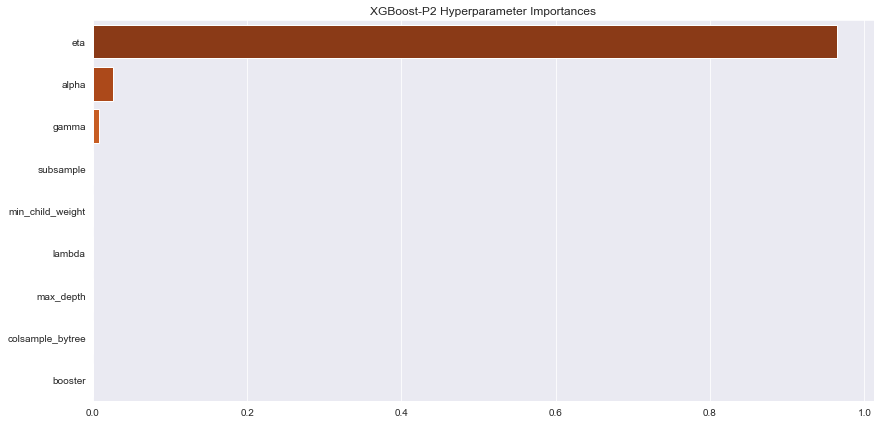

In [235]:
plot_hyperparameter_importances(xgboost_p2_study)

Train an XGBoost model on all training data using the tuned hyperparamters in order to make predictions on the testing set.

In [236]:
xgboost_p2_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=42, nthread=3, **xgboost_p2_study.best_params)

xgboost_p2_model.fit(data_train[XGBOOST_P2_FEATURES], data_train.log_price_per_sqm)

XGBRegressor(alpha=1.0688030776681168e-05, base_score=0.5, booster='dart',
             colsample_bylevel=1, colsample_bynode=1,
             colsample_bytree=0.7728087067630364, enable_categorical=False,
             eta=0.07752935477711576, gamma=0.00018406622479410044, gpu_id=-1,
             importance_type=None, interaction_constraints='',
             lambda=0.017131208303499065, learning_rate=0.0775293559,
             max_delta_step=0, max_depth=20, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=3, nthread=3,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=42, reg_alpha=1.06880307e-05,
             reg_lambda=0.0171312075, scale_pos_weight=1,
             subsample=0.7241173917439103, ...)

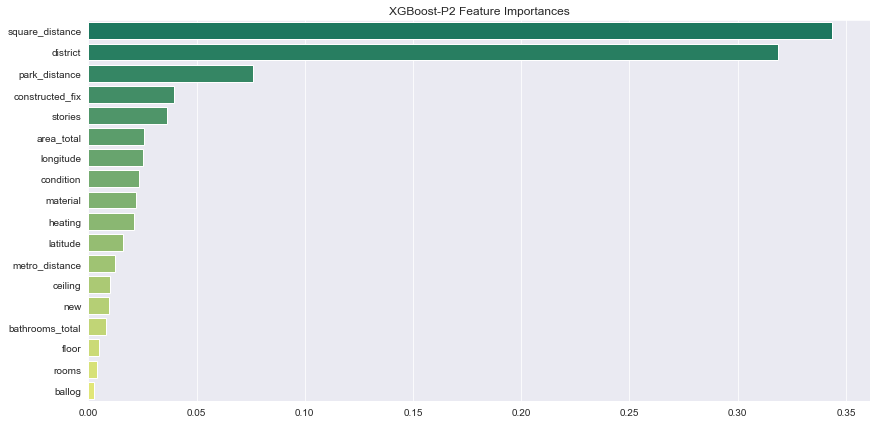

In [237]:
plot_feature_importances(XGBOOST_P2_FEATURES, xgboost_p2_model.feature_importances_, "XGBoost-P2")

In [238]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
xgboost_p2_prediction = np.exp(xgboost_p2_model.predict(data_test[XGBOOST_P2_FEATURES])) * data_test.area_total
#xgboost_p2_prediction.rename("price_prediction").to_csv("submissions/xgboost_p2.csv", index_label="id")

# CatBoost-T2LC

In [239]:
CATBOOST_T2LC_FEATURES = LIGHTGBM_F4LC_FEATURES

In [240]:
def catboost_t2lc_objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 1, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "depth": trial.suggest_int("depth", 6, 14),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.001, 100.0),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 0.001, 100.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    model = catboost.CatBoostRegressor(objective="RMSE", random_seed=42, silent=True, thread_count=1, **params)

    scores = []
    for train_idx, test_idx in kf.split(data_train[CATBOOST_T2LC_FEATURES], data_train.price):
        train, test = data_train.iloc[train_idx], data_train.iloc[test_idx]

        model.fit(train[CATBOOST_T2LC_FEATURES], train.log_price_per_sqm)

        predictions = np.exp(model.predict(test[CATBOOST_T2LC_FEATURES])) * test.area_total
        scores.append(rmsle(test.price, predictions))

    return np.mean(scores)

We try to load the Optuna study from storage. If not such study is found, we do some trials. By default, this code section runs 10 trials. While developing the models for submission to Kaggle we ran 100 trials.

In [241]:
catboost_t2lc_study = optuna.create_study(
    storage=STORAGE,
    sampler=optuna.samplers.TPESampler(seed=42),
    study_name="CatBoost-T2LC",
    direction="minimize",
    load_if_exists=True
)

if not catboost_t2lc_study.trials:
    catboost_t2lc_study.optimize(catboost_t2lc_objective, n_trials=10)
else:
    print("Some trials have already been run, skipping further optimization.")

[I 2021-11-18 19:29:20,891] Using an existing study with name 'CatBoost-T2LC' instead of creating a new one.


Some trials have already been run, skipping further optimization.


In [242]:
pd.DataFrame.from_dict({
    "Number of completed trials": (catboost_t2lc_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": catboost_t2lc_study.best_trial.number,
    "Best value": catboost_t2lc_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,91.000000
Best value,0.123653


In [243]:
pd.DataFrame.from_dict(catboost_t2lc_study.best_params, orient="index", columns=["Value"])

,Value
bagging_temperature,0.020690
depth,8.000000
iterations,995.000000
l2_leaf_reg,0.865703
learning_rate,0.129389
random_strength,3.000000


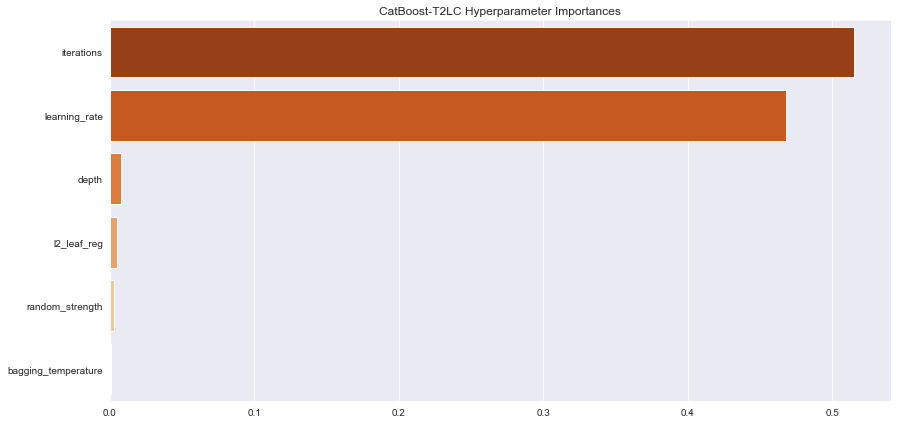

In [244]:
plot_hyperparameter_importances(catboost_t2lc_study)

Train a CatBoost model on all training data using the tuned hyperparamters in order to make predictions on the testing set.

In [245]:
catboost_t2lc_model = catboost.CatBoostRegressor(objective="RMSE", random_seed=42, silent=True, thread_count=1, **catboost_t2lc_study.best_params)

catboost_t2lc_model.fit(data_train[CATBOOST_T2LC_FEATURES], data_train.log_price_per_sqm)

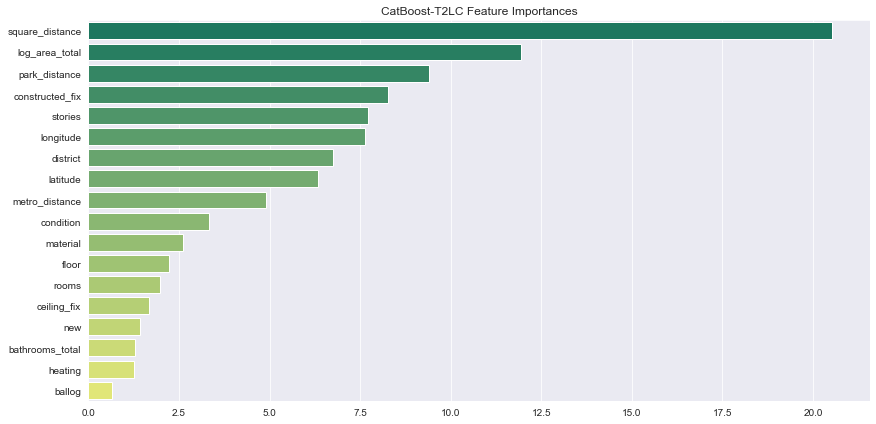

In [246]:
plot_feature_importances(CATBOOST_T2LC_FEATURES, catboost_t2lc_model.feature_importances_, "CatBoost-T2LC")

In [247]:
# Predict prices for the whole test set and write them to a correctly formatted CSV file
catboost_t2lc_prediction = np.exp(catboost_t2lc_model.predict(data_test[CATBOOST_T2LC_FEATURES])) * data_test.area_total
#catboost_t2lc_prediction.rename("price_prediction").to_csv("submissions/catboost_t2lc.csv", index_label="id")

# Weighted Average of LightGBM-F4LC and CatBoost-T2LC

Weighted by the cross-validation score of their best trial.

In [248]:
# pd.Series(
#     np.average(
#         [lightgbm_f4lc_prediction, catboost_t2lc_prediction],
#         axis=0,
#         weights=[-lightgbm_f4lc_study.best_value, -catboost_t2lc_study.best_value],
#     ),
#     index=lightgbm_f4lc_prediction.index,
#     name="price_prediction",
# ).to_csv("submissions/weighted_average_lightgbm_f4lc_and_catboost_t2lc.csv", index_label="id")

# LightGBM-2H and Catboost-2H
Don't ask us about the naming... These models use the distances to the more expensive districts and also does not use the imputing of `constructed`. They also use the features for the number of metros close etc. Thus, we were hoping that these models would capture some other aspects of the data, and maybe perform well in combination with the above models.

In [249]:
NUMERIC_FEATURES_H2 = ["latitude", "longitude", "constructed", "log_area_total", "log_area_per_room", "rooms", "metro_distance", "park_distance",
            "square_distance", "metro_close", "park_close", "square_close", "stories", "floor", "ceiling_fix", "bathrooms_total", "ballog", "distr_avg", 
            'khamo_dist', 'ostoz_dist', 'rublevka_dist', 'yaki_dist', 'arbat_dist', 'pres_dist', 'tver_dist']
            
CATEGORICAL_FEATURES_H2 = ['condition', 'district', 'garbage_chute', 'heating', 'layout', 'material',
                         'new', 'parking', 'seller', 'windows_court', 'windows_street']

In [250]:
# Objective used by Optuna.

def objective_lgb_h2(trial, X, y, area):
    params = {
        "reg_alpha": trial.suggest_loguniform("reg_alpha", 1e-3, 10.0),
        "reg_lambda": trial.suggest_loguniform("reg_lambda", 1e-3, 10.0),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
        "subsample": trial.suggest_categorical("subsample", [0.4, 0.5, 0.6, 0.7, 0.8, 1.0]),
        "learning_rate": trial.suggest_categorical("learning_rate", [0.006, 0.008, 0.01, 0.014, 0.017, 0.02, 0.03]),
        "max_depth": trial.suggest_int("max_depth", 1, 250),
        "num_leaves" : trial.suggest_int("num_leaves", 2, 1000),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 300),
        "cat_smooth" : trial.suggest_int("cat_smooth", 3, 60)
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = lgb.LGBMRegressor(random_state=SEED, metric="rmse", n_jobs=3, n_estimators=6000, **params)

    scores = []
    for idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, np.log(y_train/area[train_idx]), categorical_feature=CATEGORICAL_FEATURES_H2)

        preds = np.exp(model.predict(X_test)) * area[test_idx]
        scores.append(rmsle(y_test, preds))

    return np.mean(scores)

In [251]:
X = data_train[NUMERIC_FEATURES_H2 + CATEGORICAL_FEATURES_H2].copy()
X[CATEGORICAL_FEATURES_H2] = X[CATEGORICAL_FEATURES_H2].astype('category')

X_test = data_test[NUMERIC_FEATURES_H2 + CATEGORICAL_FEATURES_H2]
X_test[CATEGORICAL_FEATURES_H2] = X_test[CATEGORICAL_FEATURES_H2].astype('category')

y = data_train.price
area = data_train.area_total

lgb_h2_study = optuna.create_study(
    storage="sqlite:///resources/jim_optuna.sqlite",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name="LightGBM-h2",
    direction="minimize",
    load_if_exists=True
)

lgb_h2_mod = lgb.LGBMRegressor(random_state=SEED, metric="rmse", n_jobs=3, n_estimators=6000, **lgb_h2_study.best_params)
lgb_h2_mod.fit(X, np.log(y/area), categorical_feature=CATEGORICAL_FEATURES_H2)

[I 2021-11-18 19:29:37,814] Using an existing study with name 'LightGBM-h2' instead of creating a new one.


LGBMRegressor(boosting_type='gbdt', cat_smooth=8, class_weight=None,
              colsample_bytree=0.4, importance_type='split',
              learning_rate=0.006, max_depth=32, metric='rmse',
              min_child_samples=1, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=6000, n_jobs=3, num_leaves=327, objective=None,
              random_state=42, reg_alpha=0.04332781805200478,
              reg_lambda=0.02011247431970239, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

In [252]:
pd.DataFrame.from_dict({
    "Number of completed trials": (lgb_h2_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": lgb_h2_study.best_trial.number,
    "Best value": lgb_h2_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,164.000000
Best trial,164.000000
Best value,0.115934


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

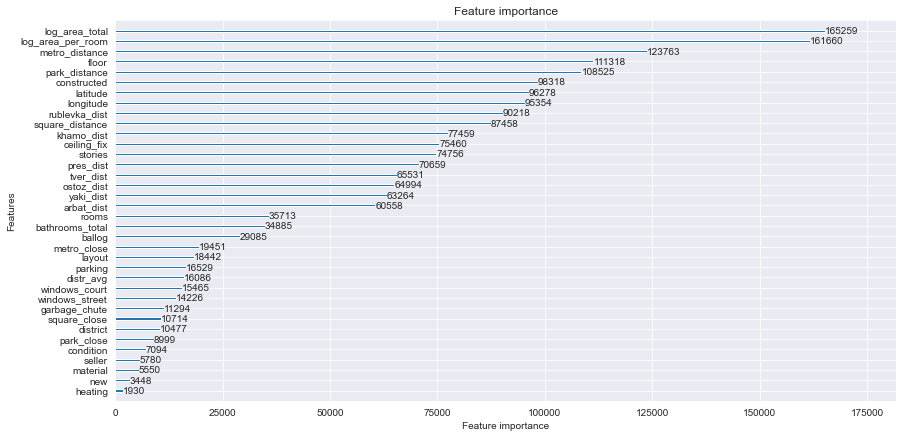

In [253]:
lgb.plot_importance(lgb_h2_mod)

We observe that all the features related to the expensive districts have high importance.

In [254]:
lgb_h2_preds = np.exp(lgb_h2_mod.predict(X_test)) * data_test.area_total

In [255]:
# Objective used by Optuna.

def objective_cat_h2(trial, X, y, area):
    params = {
        "iterations": trial.suggest_int("iterations", 1, 1000),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.001, 0.5),
        "depth": trial.suggest_int("depth", 6, 14),
        "l2_leaf_reg": trial.suggest_loguniform("l2_leaf_reg", 0.001, 100.0),
        "random_strength": trial.suggest_int("random_strength", 0, 100),
        "bagging_temperature": trial.suggest_loguniform("bagging_temperature", 0.001, 100.0),
    }

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    model = catboost.CatBoostRegressor(objective="RMSE", random_seed=SEED, silent=True, thread_count=4, **params)

    scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(kf.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model.fit(X_train, np.log(y_train/area[train_idx]), cat_features = ['district'])

        preds = np.exp(model.predict(X_test)) * area[test_idx]
        scores[idx] = rmsle(y_test, preds)

    return np.mean(scores)

In [256]:
cat_h2_study = optuna.create_study(
    storage="sqlite:///resources/jim_optuna.sqlite",
    sampler=optuna.samplers.TPESampler(seed=SEED),
    study_name="cat-lh",
    direction="minimize",
    load_if_exists=True
)

X = data_train[NUMERIC_FEATURES_H2 + CATEGORICAL_FEATURES_H2].copy()
X['district'] = X['district'].astype(int)
X_test = data_test[NUMERIC_FEATURES_H2 + CATEGORICAL_FEATURES_H2]
X_test['district'] = X_test['district'].astype(int)

cat_h2_mod = catboost.CatBoostRegressor(objective="RMSE", random_seed=SEED, silent=True, thread_count=4, **cat_h2_study.best_params)
cat_h2_mod.fit(X, np.log(y/area), cat_features = ['district'])

[I 2021-11-18 19:31:05,852] Using an existing study with name 'cat-lh' instead of creating a new one.


In [257]:
pd.DataFrame.from_dict({
    "Number of completed trials": (cat_h2_study.trials_dataframe().state == "COMPLETE").sum(),
    "Best trial": cat_h2_study.best_trial.number,
    "Best value": cat_h2_study.best_value,
}, orient="index", columns=[""])

,
Number of completed trials,100.000000
Best trial,98.000000
Best value,0.124729


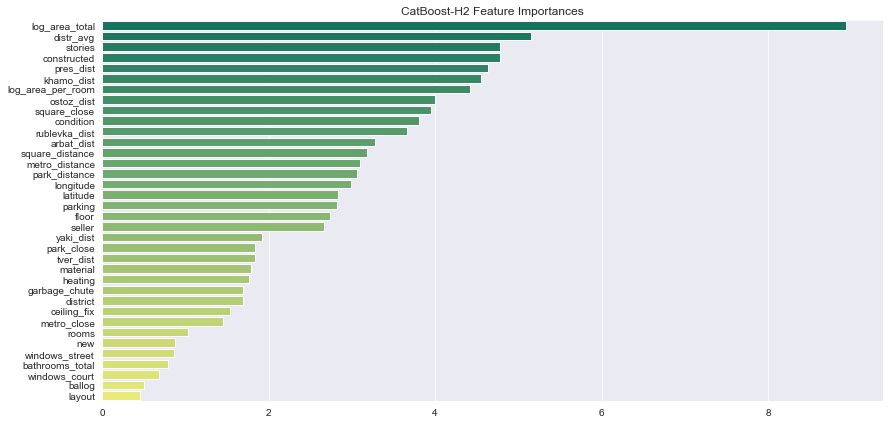

In [258]:
plot_feature_importances(NUMERIC_FEATURES_H2 + CATEGORICAL_FEATURES_H2, cat_h2_mod.feature_importances_, "CatBoost-H2")

The importance plot generated by CatBoost is quite different from LightGBM. For example, `ditr_avg` is the second most important here, while scoring quite low for LightGBM-H2.

In [259]:
cat_h2_preds = np.exp(cat_h2_mod.predict(X_test)) * data_test.area_total

To conclude, we found that the LightGBM and CatBoost models complemented each other nicely, and our best submission was the weighted average of the model predictions which you can see below. The predictions are weighted by the CV-score of each model.

In [260]:
best_preds = np.average(
        [lightgbm_f4lc_prediction, catboost_t2lc_prediction, lgb_h2_preds, cat_h2_preds],
        axis=0,
        weights=[ -lightgbm_f4lc_study.best_value, -catboost_t2lc_study.best_value, 
                  -lgb_h2_study.best_value, -cat_h2_study.best_value],
    )